# Importing Libraries

In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path1='/content/drive/MyDrive/Clean_text.txt'
path2='/content/drive/MyDrive/combined_text.txt'
path3='/content/drive/MyDrive/cleaned_output.txt'

In [4]:
file1 = open(path1, 'rb').read().decode(encoding='utf-8')
file2 = open(path2, 'rb').read().decode(encoding='utf-8')
file3 = open(path3, 'rb').read().decode(encoding='utf-8')

In [5]:
combined_file='final_combined_text.txt'

# Merging Dataset

In [6]:
import shutil

def merge_files_with_shutil(file1, file2,file3, merged_file):
    with open(merged_file, 'wb') as outfile:
        for filename in [file1, file2,file3]:
            with open(filename, 'rb') as infile:
                shutil.copyfileobj(infile, outfile)


merge_files_with_shutil(path1, path2,path3, combined_file)

In [7]:
combined_text= open(combined_file, 'rb').read().decode(encoding='utf-8')

In [8]:
import string
combined_text=combined_text.strip(string.punctuation)

In [9]:
combined_text=combined_text.lower()

In [10]:
combined_text

'title agriculture census pakistan bureau of statistics agriculture census pakistan bureau of statistics skip to main content search search main navigation home about us contacts tenders jobs related links data request nsdp faqs disability statistics pbs datafest 2024 home introduction agriculture census organization aco was established in 1958 as an attached department of the then ministry of agriculture under the legal cover of agriculture census act 1958. immediately after its inception, aco conducted agriculture census of 1960 to fulfill national and international requirements of data on agriculture. later on, this organization conducted a surveycumcensus under the recommendation of the farm mechanization committee, government of pakistan, in 1968 and an agriculture census in 1972 which was actually due in 1970. two years delay in the conduct of agriculturel census was on account of disturbed political environment in the country and war with india. subsequently, aco conducted lives

# Pretained Embedding model Sentence Transformer loading

In [11]:
# Load the pretrained sentence transformer model
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Tokenization

In [12]:
# Tokenize the text into words
words = combined_text.split()

# Encode each word using the pretrained embedding model
encoded_words = np.array([sentence_transformer.encode(word) for word in words])

# Display the shape of encoded data
print("Shape of encoded words:", encoded_words.shape)

Shape of encoded words: (46377, 384)


# Creating input/output sequences

In [13]:
# Define sequence length
seq_length = 10  # Number of words to use as context for prediction

# Prepare input-output sequences
input_sequences = []
output_sequences = []

for i in range(len(encoded_words) - seq_length):
    input_sequences.append(encoded_words[i:i+seq_length])
    output_sequences.append(encoded_words[i+seq_length])

input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

print("Shape of input sequences:", input_sequences.shape)
print("Shape of output sequences:", output_sequences.shape)

Shape of input sequences: (46367, 10, 384)
Shape of output sequences: (46367, 384)


# Train Test Split

In [23]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, output_sequences, test_size=0.2, random_state=42
)

# Model Building and Training

In [30]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the improved RNN model
model = Sequential([
    LSTM(512, input_shape=(seq_length, encoded_words.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(512),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(encoded_words.shape[1])  # Output size matches the word embedding dimensions
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 10, 512)             │       1,837,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 384)                 │          98,688 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,166,272 (15.89 MB)

 Trainable params: 4,166,272 (15.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 5/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 6/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 9/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s

# Train-Validation Loss Graph

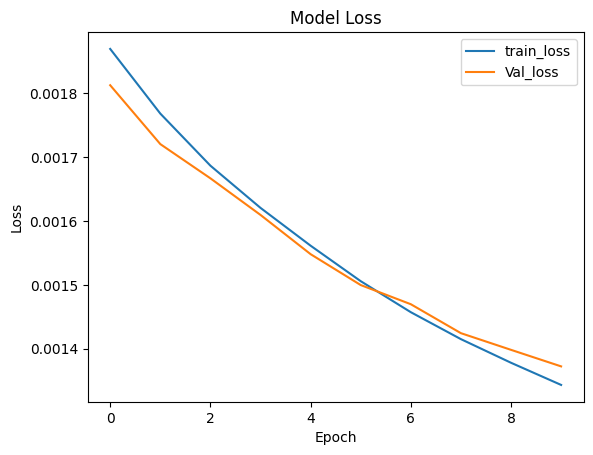

In [31]:
# Save the training and validation loss images
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model1_loss.png')
plt.show()

# Generating the text

In [32]:
def generate_text(model, start_words, gen_length=10):
    # Encode the starting words using the sentence transformer model
    input_eval = np.array([sentence_transformer.encode(word) for word in start_words.split()])
    input_eval = np.expand_dims(input_eval, axis=0)  # Add batch dimension

    generated_text = start_words

    for _ in range(gen_length):
        # Predict the next word embedding
        predictions = model.predict(input_eval)
        predicted_word_embedding = predictions[0]  # Extract the predicted embedding

        # Find the closest word in the dataset based on the predicted embedding
        distances = np.linalg.norm(encoded_words - predicted_word_embedding, axis=1)
        closest_word_idx = np.argmin(distances)
        next_word = words[closest_word_idx]

        # Append the word to the generated text
        generated_text += " " + next_word

        # Prepare the input for the next iteration
        next_word_embedding = np.expand_dims(sentence_transformer.encode(next_word), axis=0)
        input_eval = np.append(input_eval[:, 1:, :], next_word_embedding[:, None, :], axis=1)

    return generated_text


In [33]:
# Seed text to start generating text
seed_text = "pakistan bureau of statistics"
generated_output = generate_text(model, seed_text, gen_length=20)
print("Generated Output:")
print(generated_output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Generated Output:
pakistan bureau of statistics the job in the gov of pakistan the the government of the district, judicial name of jurisdiction in the job


In [34]:
pip install rouge_score

# Model Evaluation

In [35]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Generate text and evaluate against a reference text
def evaluate_model(model, seed_text, reference_text, gen_length=10):

    # Generate text using the model
    generated_text = generate_text(model, seed_text, gen_length)

    # Tokenize texts into words
    generated_tokens = generated_text.split()
    reference_tokens = reference_text.split()

    print("Generated Tokens:", generated_tokens[:20])  # Display first 20 tokens for reference
    print("Reference Tokens:", reference_tokens[:20])  # Display first 20 tokens for reference

    # Calculate BLEU Score
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)
    print(f"BLEU Score: {bleu_score:.4f}")

    # Calculate ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_text, generated_text)

    print("ROUGE Scores:")
    for metric, score in rouge_scores.items():
        print(f"{metric}: Precision: {score.precision:.4f}, Recall: {score.recall:.4f}, F1: {score.fmeasure:.4f}")

# Example usage for evaluation
seed_text = "pakistan bureau of statistics"
reference_text = "Pakistan Bureau of Statistics is a government organization responsible for conducting and analyzing various statistical data."
evaluate_model(model, seed_text, reference_text, gen_length=30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [36]:
# Save the model checkpoint
model.save('RNN_with_pre_trained_checkpoint.h5')